In [102]:
from pathlib import Path
import ss_deterministic_model
import torch
from torch.utils.data import TensorDataset, DataLoader

import pyro

import pandas as pd
import matplotlib.pyplot as plt

from pyro_hmmiopl import HMMIOpl, fit
import pyro_hmmio as hmm
from ss_deterministic_model import StateSpaceModel

import numpy as np

%matplotlib widget

### Data z 9. 1. 2022

In [79]:
dataroot = Path('N:\Datasets\TimeSeries\data_sources\pece-potraviny-j4\mereni220109')
filenames = [
    'UI_001 2022-01-09 12.25.26.713.csv',
    'UI_002 2022-01-09 12.45.27.014.csv',
    'UI_003 2022-01-09 13.05.27.313.csv',
    'UI_004 2022-01-09 17.35.27.713.csv',
    'UI_005 2022-01-09 17.55.28.113.csv',
]
time_origins = [
    pd.to_datetime('09.01.2022 12:05:31 912', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 12:25:27 113', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 12:45:27 413', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 17:15:31 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 17:35:28 213', format='%d.%m.%Y %H:%M:%S %f', utc=True),
]

### Data z 16. 1. 2022

In [80]:
dataroot = Path('N:\Datasets\TimeSeries\data_sources\pece-potraviny-j4\mereni220116')
# dataroot = Path('D:\DATA_FAST\pece-potraviny-j4\mereni220116')
filenames = [
    'UI_004 2022-01-16 17.12.09.113.csv',
    'UI_001 2022-01-16 13.08.47.913.csv',
    'UI_002 2022-01-16 14.12.08.214.csv',
    'UI_003 2022-01-16 16.12.08.614.csv',
]
time_origins = [
    pd.to_datetime('16.01.2022 16:12:11 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('16.01.2022 12:08:51 912', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('16.01.2022 13:12:11 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('16.01.2022 15:12:11 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
]

In [81]:
tag_map = {
    'Sample': 'Sample',
    'X(ms) [09.01.2022 12:45:27 413 UTC]': 'Time [ms]',
    'doughInProofer[%MB99]':    'doughInProofer [%]',
    'DB_analog_convertor.temp_zone[0].AWGoutInt':   'Temperature measured [C]',
    'DB_Data_source_HMI_S7.HMI.temp_Z01':   'Temperature set [C]',
    'DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[0]':  'Bottom heater binary',
    'DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[1]':  'Top heater binary',
    'DB_product_position.zone[0].AVG':  'doughInProofer smoothed',
    'DB_Electrical_heaters_REQ1.zone_power[0, 0]':  'Bottom heater cont',
    'DB_Electrical_heaters_REQ1.zone_power[1, 0]':  'Top heater cont',
    'IEC_Timer_Brumuddal_Kotlever_delay.IN':    'Product at input binary',
    'DB_productPositionBrumuddal.zone[0].AVG':   'Occupancy average'
}


In [82]:
dfs = [
    pd.read_csv(dataroot/filename)  #, header=0, names=tag_map.values())
    for filename in filenames
]

df = dfs[0]

### Check consistency

In [83]:
correspondence = zip(dfs[0].columns, tag_map.values())

for i, col in enumerate(correspondence):
    print(f'{i}:{col}')

0:('Sample', 'Sample')
1:('X(ms) [16.01.2022 16:12:11 913 UTC]', 'Time [ms]')
2:('doughInProofer[%MB99]', 'doughInProofer [%]')
3:('DB_analog_convertor.temp_zone[0].AWGoutInt', 'Temperature measured [C]')
4:('DB_Data_source_HMI_S7.HMI.temp_Z01', 'Temperature set [C]')
5:('DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[0]', 'Bottom heater binary')
6:('DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[1]', 'Top heater binary')
7:('DB_product_position.zone[0].AVG', 'doughInProofer smoothed')
8:('DB_Electrical_heaters_REQ1.zone_power[0; 0]', 'Bottom heater cont')
9:('DB_Electrical_heaters_REQ1.zone_power[1; 0]', 'Top heater cont')
10:('IEC_Timer_Brumuddal_Kotlever_delay.IN', 'Product at input binary')
11:('DB_productPositionBrumuddal.zone[0].AVG', 'Occupancy average')


In [84]:
for df in dfs:
    df.columns = tag_map.values()

out_smooth = df['Temperature measured [C]'].ewm(com=0.5).mean()

output_seqs = torch.stack([
    torch.tensor(df['Temperature measured [C]'].to_numpy())
    for df in dfs
]).unsqueeze(-1).unsqueeze(-1).double()

# for df in dfs:
#     df['Bottom heater masked'] = df['Bottom heater binary'] * df['Bottom heater cont']
#     df['Top heater masked'] = df['Top heater binary'] * df['Top heater cont']

input_seqs = torch.stack([
    torch.tensor(df[['Bottom heater binary',
       'Top heater binary',
       'Bottom heater cont',
       'Top heater cont',
       'Occupancy average']].to_numpy())
    for df in dfs
]).double()

print(f'Outputs are of shape {output_seqs.shape}')
print(f'Inputs are of shape {input_seqs.shape}')



Outputs are of shape torch.Size([4, 360, 1, 1])
Inputs are of shape torch.Size([4, 360, 5])


Data z `doughInProofer smoothed` jsou zpožděná o cca 15 min. Vyšetříme korelaci pro časové zpoždění v daném rozsahu počtu samplů 70 - 90.

Pracovní bod pro teplotu jsme zafixovali - odečte se od dat před samotným fitováním.

In [176]:
from gp_approx_single_taskpl import fit, SingleApproxGPpl

operating_temp = 225.

num_inducing=20
num_iter=1000
lr=0.1
patience = 50
use_predictive_mll = True
learn_inducing_locations = False
slow_mode = False  # enables checkpointing and logging

time_range = (0, 1.)


# Generate synthetic data
# here we generate some synthetic samples
Y_tens = output_seqs[1].squeeze()-operating_temp
print(Y_tens.shape)
NSamp = Y_tens.size(0)
datalength = NSamp
print(f'NSamp = {NSamp}')
X_tens = torch.linspace(time_range[0], time_range[1], NSamp)

model_smoother = SingleApproxGPpl(
    num_inducing=num_inducing,
    time_range=(X_tens[0], X_tens[-1]),
    lr=lr,
    learn_inducing_locations = learn_inducing_locations,
    use_predictive_mll = use_predictive_mll,
    datalength=datalength
)

loader = DataLoader(
    TensorDataset(
        X_tens,
        Y_tens
    ),
    batch_size=8256,
    shuffle=True
)
fit(model_smoother,
    train_dataloader=loader,
    max_epochs=num_iter,
    patience=patience,
    verbose=False,
    enable_checkpointing=slow_mode,
    enable_logger=True)

c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type                    | Params
-------------------------------------------------
0 | gp   | SingleApproxGP          | 424   
1 | mll  | PredictiveLogLikelihood | 424   
-------------------------------------------------
424       Trainable params
0         Non-trainable params
424       Total params
0.002     Total estimated model params size (MB)
c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottlenec

torch.Size([360])
NSamp = 360
Epoch 427: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, loss=0.35, v_num=26, train_loss=0.342]  


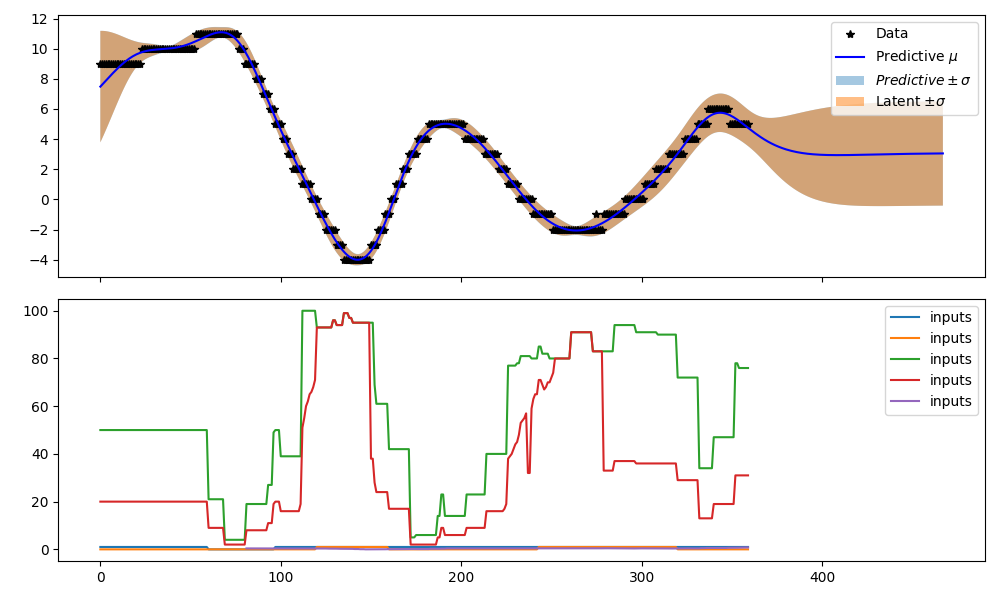

In [177]:
import gpytorch

X_tens_pred = torch.linspace(time_range[0], 1.3*time_range[1], round(1.3*NSamp))

model_smoother.eval()
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model_smoother.predict(X_tens_pred)
    latents = model_smoother(X_tens_pred)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    lat_lower, lat_upper = latents.confidence_region()

    Y_tens_smoothed = latents.mean

time = torch.arange(X_tens_pred.size(0))


fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax[0].plot(Y_tens.squeeze(), 'k*', label='Data')
# Predictive mean as blue line
ax[0].plot(time, mean.numpy(), 'b', label='Predictive $\mu$')
# Shade in confidence
ax[0].fill_between(time, lower.numpy(), upper.numpy(), alpha=0.4, label='$Predictive \pm\sigma$')
ax[0].fill_between(time, lat_lower.numpy(), lat_upper.numpy(), alpha=0.5, label='Latent $\pm\sigma$')
ax[0].legend()

# pred_var = predictions.covariance_matrix.diag().detach()  # point variances of predictions
# ax[1].plot(pred_var, label='Pred. variance')
ax[1].plot(input_seqs[1, ...], label='inputs')
ax[1].legend()

fig.tight_layout()

Precision of temperature sensor is visibly 1 degree of Celsius. This needs to be interpolated and smoothed.

### Fit model on data
Protože máme pro trénování k dispozici data zpožděná o 15 minut, zahazujeme prvních 15 dat a fitujeme pouze na datech s akčními zásahy bez zpoždění.

Best lag: 85


,Occupancy average,doughInProofer smoothed lagged
Occupancy average,1.000000,0.918334
doughInProofer smoothed lagged,0.918334,1.000000


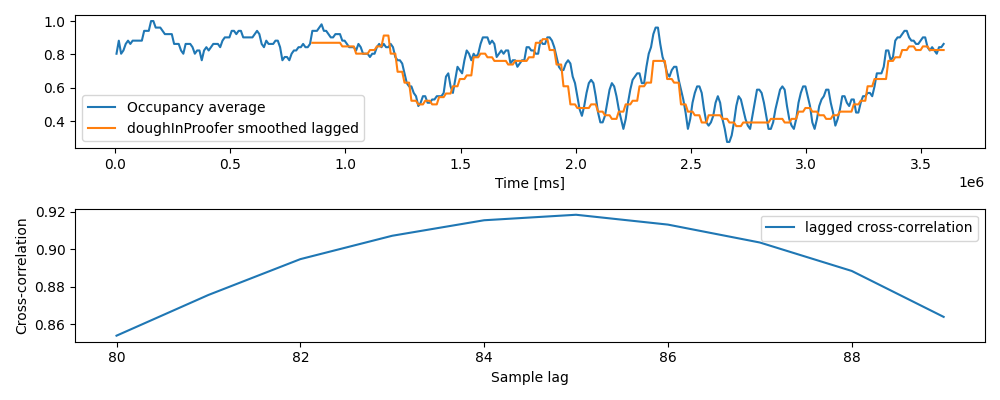

In [144]:
example_idx = 3

fn_crosscorr = lambda a, b, lag: a.corr(b.shift(lag))
lag_range = np.arange(80, 90)
xcov_sliding = [
    fn_crosscorr(dfs[example_idx]['Occupancy average'],
              dfs[example_idx]['doughInProofer smoothed'], lag=i)
    for i in lag_range
]

best_lag = lag_range[np.argmax(xcov_sliding)]
print(f'Best lag: {best_lag}')

fig, ax = plt.subplots(2, 1, figsize=(10, 4))
dfs[example_idx]['doughInProofer smoothed lagged'] = dfs[example_idx]['doughInProofer smoothed'].shift(best_lag)
# dfs[example_idx]['doughInProofer [%] lagged'] = dfs[example_idx]['doughInProofer [%]'].shift(best_lag)/100.
cols_to_plot = set(dfs[example_idx].columns) - {'Sample',
            # 'Time [ms]',
            'Bottom heater cont',
            'Bottom heater binary', 
            'Top heater cont',
            'Top heater binary',
            'Temperature set [C]',
            'Temperature measured [C]',
            'Product at input binary',
            'doughInProofer [%]',
            'doughInProofer smoothed'
            }
dfs[example_idx][cols_to_plot].plot(x='Time [ms]', ax=ax[0])
ax[1].plot(lag_range, xcov_sliding, label='lagged cross-correlation')
ax[1].legend()
ax[1].set_xlabel('Sample lag')
ax[1].set_ylabel('Cross-correlation')
fig.tight_layout()

dfs[example_idx][cols_to_plot-{'Time [ms]'}].corr()


Set learning configuration:

In [184]:
learning_rate = 0.05
max_epochs = 6000
patience = 100
minibatch_size = 1
hidden_dim = 1
num_particles = 30
min_delta = 0

input_seqs = torch.stack([
    torch.tensor(df[['Bottom heater binary',
       'Top heater binary',
       'Bottom heater cont',
       'Top heater cont',
       'doughInProofer smoothed lagged']].to_numpy())
    for df in dfs
]).double()

inputs = input_seqs[example_idx, best_lag:, ...].unsqueeze(0)
outputs = Y_tens_smoothed[best_lag:].view(1, -1, 1, 1)
Y_tens_lagged = Y_tens[best_lag:]
print(f'inputs: {inputs.shape}')
print(f'outputs: {outputs.shape}')
print(f'raw_lagged: {Y_tens_lagged.shape}')

input_dim = inputs.size(-1)
obs_dim = outputs.size(-2)
num_sequences = outputs.size(0)
length = outputs.size(1)

inputs: torch.Size([1, 275, 5])
outputs: torch.Size([1, 383, 1, 1])
raw_lagged: torch.Size([275])


In [185]:
model = HMMIOpl(
    hidden_dim=hidden_dim,
    input_dim=input_dim,
    obs_dim=obs_dim,
    lr=learning_rate,
    num_particles=num_particles,
    minibatch_size=minibatch_size
)

loader = DataLoader(
    TensorDataset(
        inputs,
        outputs
    ),
    batch_size=10000,
    shuffle=False
)


In [186]:
fit(model,
    train_dataloader=loader,
    max_epochs=max_epochs,
    patience=patience,
    min_delta=min_delta,
    verbose=False,
    enable_logger=True,
    enable_checkpointing=False)

c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\optimizers.py:37: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The datalo

Epoch 5999: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, v_num=28, train_loss=2.29e+4]


In [187]:
param_store = pyro.get_param_store()
for key, val in param_store.items():
    print(f'{key}:\n\t{val}')

a_params_dict = {
    'a_mean': pyro.param('a_mean'),
    'a_offdiag1': pyro.param('a_offdiag1'),
}
a = hmm.form_a(a_params_dict)
print(f'Param A:\n{a}')

q:
	tensor([0.0046, 0.0051], dtype=torch.float64, grad_fn=<AddBackward0>)
a_mean:
	tensor([0.0100], dtype=torch.float64, grad_fn=<AddBackward0>)
a_offdiag1:
	tensor([0.0495], dtype=torch.float64, grad_fn=<ClampBackward1>)
b:
	tensor([[ 0.0345,  3.7892, -0.8685,  1.2956,  2.8199],
        [ 1.0456,  2.6557,  0.8554, -1.2883,  2.3187]], dtype=torch.float64,
       requires_grad=True)
mu_0:
	tensor([[7.8259, 6.5511]], dtype=torch.float64, requires_grad=True)
r:
	tensor([[0.1975]], dtype=torch.float64, grad_fn=<AddBackward0>)
c:
	tensor([[0.5530, 0.5673]], dtype=torch.float64, requires_grad=True)
Param A:
tensor([[ 0.0100, -0.0495],
        [ 0.0495,  0.0100]], dtype=torch.float64, grad_fn=<SubBackward0>)


In [188]:
pyro.param('mu_0')

tensor([[7.8259, 6.5511]], dtype=torch.float64, requires_grad=True)

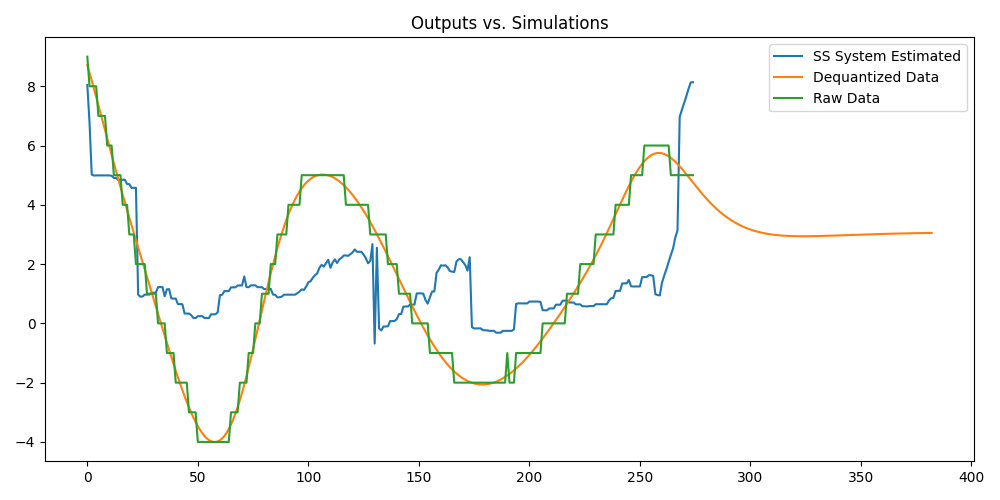

In [189]:
a_params_dict = {
    'a_mean': pyro.param('a_mean'),
    'a_offdiag1': pyro.param('a_offdiag1'),
}
a = hmm.form_a(a_params_dict)

mdl_reconstructed = StateSpaceModel(a,
                                    pyro.param('b'),
                                    pyro.param('c'))
x, y = mdl_reconstructed.simulate(inputs, x0=pyro.param('mu_0').unsqueeze(-1))
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.plot(y.detach().squeeze(), label=f'SS System Estimated')
axes.plot(outputs.detach().squeeze(), label=f'Dequantized Data')
axes.plot(Y_tens_lagged.squeeze(), label=f'Raw Data')
axes.legend()
axes.set_title(f'Outputs vs. Simulations')
plt.tight_layout()
# plt.show()
# print('Main is done')

In [ ]:
unit_step = torch.zeros_like(inputs, dtype=torch.double)
unit_step[:, 10:, 0] = 1.
x, y = mdl_reconstructed.simulate(unit_step)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.plot(y.detach().squeeze(), label=f'SS System Response')
axes.legend()
axes.set_title(f'Simulation of Unit Step Response')
plt.tight_layout()